In [332]:
from datetime import timedelta, date
import datetime
import numpy as np
import pandas as pd
import string
import re
import csv
import requests
import string
from copy import deepcopy, copy
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import plotly
import plotly.plotly as py
from plotly.graph_objs import *
plotly.tools.set_credentials_file(username='aabid0193', api_key='xJKtUA3jiPLjTQThzQUk')
import scipy

%matplotlib inline

plt.style.use('seaborn')

The additional data we chose to use was census data. The data was found on Kaggle and contained partially aggregated 2017 data for each census block regarding the respondents' sex, race, employment status, employment industry, transportation preference - among other metrics. For our analysis we will focus on sex, employment industry, and transportation preference.

In [660]:
# read data from saved csv files
df_census = pd.read_csv('nyc_census_tracts.csv', delimiter = ',', header = 0, skipinitialspace = True)
df_census_loc = pd.read_csv('census_block_loc.csv', delimiter = ',', header = 0, skipinitialspace = True)

In [661]:
# create a new dataframe with only the columns we are interested in
df_census_sub = df_census[["CensusTract","County","Borough","TotalPop","Women","Income","Poverty","Professional","Transit","Employed"]].copy()

In [250]:
df_census_sub.head()

,CensusTract,County,Borough,TotalPop,Women,Income,Poverty,Professional,Transit,Employed
0,36005000100,Bronx,Bronx,7703,570,NaN,NaN,NaN,NaN,0
1,36005000200,Bronx,Bronx,5403,2744,72034.0,20.0,28.7,38.6,2308
2,36005000400,Bronx,Bronx,5915,3019,74836.0,13.2,32.2,44.6,2675
3,36005001600,Bronx,Bronx,5879,3321,32312.0,26.3,19.1,45.5,2120
4,36005001900,Bronx,Bronx,2591,1385,37936.0,37.1,35.4,63.9,1083


In [663]:
# select only census data from within NY
df_census_loc = df_census_loc[(df_census_loc["State"] == 'NY')]

The census location data has an identifier for the census block, but this identifier has more digits to signify a more specific location slice. In order to match up the location with the census data, we need to cut down the identifier to the appropriate specificity. 

In [254]:
# create a copy of the BlockCode as a string so that we can perform slicing
df_census_loc["CensusTract"] = df_census_loc["BlockCode"].apply(str)

In [255]:
df_census_loc["CensusTract"] = df_census_loc["CensusTract"].str[:-4]

In [257]:
# set the CensusTract string back to an integer type so that the data types will match when merging later on
df_census_loc["CensusTract"] = df_census_loc["CensusTract"].apply(int)

Since there are multiple BlockCodes per CensusTracts, we want to find the average coordinates for each CensusTract. Thus when we merge dataframes, there are no duplicates.

In [258]:
df_census_loc["Avg_Lat"] = df_census_loc.groupby(["CensusTract"])["Latitude"].transform(lambda x: x.mean())

In [259]:
df_census_loc["Avg_Long"] = df_census_loc.groupby(["CensusTract"])["Longitude"].transform(lambda x: x.mean())

In [260]:
# create a new dataframe that contains only CensusTract ID and the matching average geographical coordinates
df_census_coord = df_census_loc[["CensusTract","Avg_Lat","Avg_Long"]].copy()

In [261]:
# drop duplicates so there is only one record per CensusTract. the duplicates came from the transform function above.
df_census_coord.drop_duplicates(["CensusTract","Avg_Lat","Avg_Long"], keep = 'first', inplace = True)

Now we have a dataframe with CensusTract ID and the geographical coordinates, and a dataframe with census data per CensusTract ID. Now we need to merge these into one dataframe so we can look at census metrics by geographical location.

In [263]:
# create a new dataframe by adding 3 columns from our location dataframe into the census data dataframe
df_census_merge = pd.merge(df_census_sub,df_census_coord[["CensusTract","Avg_Lat","Avg_Long"]],on='CensusTract')

Looking below, we can see that there are different numbers of nulls per metric. The nulls can't be used, but removing records for any nulls isn't the best approach. Instead, we split the data up by metric into separate dataframes to clean and analyze.

In [659]:
df_census_merge.isnull().sum()

CensusTract      0
County           0
Borough          0
TotalPop         0
Women            0
Income          66
Poverty         42
Professional    43
Transit         43
Employed         0
Avg_Lat          0
Avg_Long         0
dtype: int64

In [289]:
df_census_sex = df_census_merge[["CensusTract","County","Borough","TotalPop","Women","Avg_Lat","Avg_Long"]].copy()

In [539]:
df_census_transit = df_census_merge[["CensusTract","County","Borough","TotalPop","Women","Transit","Avg_Lat","Avg_Long"]].copy()

In [587]:
df_census_empl = df_census_merge[["CensusTract","County","Borough","TotalPop","Women","Professional","Employed","Avg_Lat","Avg_Long"]].copy()

In [278]:
df_census_poverty = df_census_merge[["CensusTract","County","Borough","TotalPop","Women","Poverty","Avg_Lat","Avg_Long"]].copy()

Now we can remove any records representing a lack of response for each metric within its own dataframe. For transit percent, for example, this would be a NaN value. For the total population, this would be 0. 

In [540]:
df_census_transit.dropna(axis=0, how='any',inplace=True)

In [280]:
df_census_poverty.dropna(axis=0, how='any',inplace=True)

In [ ]:
# compare how many non-responses would be removed compared to the full dataset sizsei
df_census_sex[(df_census_sex["TotalPop"]==0) & (df_census_sex["Women"] == 0)].groupby(["County","Borough"])["CensusTract"].count()

In [291]:
df_census_sex[(df_census_sex["TotalPop"]>0) & (df_census_sex["Women"] > 0)].groupby(["County","Borough"])["CensusTract"].count()

County    Borough      
Bronx     Bronx            331
Kings     Brooklyn         747
New York  Manhattan        278
Queens    Queens           647
Richmond  Staten Island    108
Name: CensusTract, dtype: int64

In [295]:
# remove the non responses
df_census_sex = df_census_sex[(df_census_sex["TotalPop"]>0) & (df_census_sex["Women"] > 0)]

Now let's bring in the station location data for reference.

In [286]:
df_stations = pd.read_csv('stations.csv', delimiter = ',', header = 0, skipinitialspace = True)

In [300]:
# limit dataset to only the locational information that we need
df_stations = df_stations[["Stop Name","GTFS Latitude","GTFS Longitude"]]

We want to identify for each CensusTract, which station is closest. Then we will be able to aggregate metrics by station. To do this, we use Scipy's KDTree.

In [303]:
# create an array of coordinates for the reference stations that will be used in nearest neighbor function
station_array = df_stations[["GTFS Latitude","GTFS Longitude"]].values

In [304]:
# create an array of coordinates for the census data that will be used in nearest neighbor function
sex_array = df_census_sex[["Avg_Lat","Avg_Long"]].values

In [307]:
def find_nearest(ref_array,target_array):
    """
    This function takes in a reference array and a target array, 
    and returns a list of indices corresponding to the reference array
    representing the nearest location for each element in the target array.
    """
    ref_tree = scipy.spatial.cKDTree(ref_array)
    dist, indices = ref_tree.query(target_array, k=1)
    return indices

results = find_nearest(station_array,sex_array)

In [321]:
# copy the nearest neighbor indices into a column in the dataframe
df_census_sex['nearest_station_index'] = results

In [329]:
# check the kdtree result array 
df_stations.loc[results,:].head()

,Stop Name,GTFS Latitude,GTFS Longitude
373,Longwood Av,40.816104,-73.896435
368,St Lawrence Av,40.831509,-73.867618
366,Castle Hill Av,40.834255,-73.851222
367,Parkchester,40.833226,-73.860816
376,Cypress Av,40.805368,-73.914042


In [430]:
# create a merged dataframe that has info on Women counts + station location
df_station_sex = pd.merge(df_stations.reset_index(), df_census_sex, right_on="nearest_station_index", left_on="index", how='right')

In [432]:
# remove unneeded columns
df_station_sex.drop(columns=["index","Avg_Lat","Avg_Long","nearest_station_index"], inplace=True)

In [433]:
# add a column indicating the total count of women responding with respect to the nearest station
df_station_sex["Tot_Women_By_Station"] = df_station_sex.groupby(["Stop Name"])["Women"].transform(lambda x: sum(x))

In [434]:
# add a column indicating the total count of women responding to the survey overall
df_station_sex["Tot_Women"] = df_station_sex["Women"].sum()

In [435]:
# add a column which represents the percentage of women responding to the survey per closest station
df_station_sex["Women_Pct"] = (df_station_sex["Tot_Women_By_Station"]/df_station_sex["Tot_Women"])*100

Now that we have aggregated metrics by station, we don't need the other columns and we can select only the unique values of interest.

In [437]:
# keep only one record per unique key of Stop Name, Station coordinates, Aggregated metrics
df_station_sex.drop_duplicates(["Stop Name"], keep = 'first', inplace = True)

In [491]:
df_station_sex_graph = df_station_sex[["Stop Name","GTFS Latitude","GTFS Longitude","Women_Pct","CensusTract"]].copy()

In [401]:
# attempt to plot a heatmap. this didn't return clear results.
df_station_sex_graph['text'] = df_station_sex_graph["Stop Name"] + '' + 'Women: ' + df_station_sex_graph['Women_Pct'].astype(str)

scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_station_sex_graph['GTFS Longitude'],
        lat = df_station_sex_graph['GTFS Latitude'],
        text = df_station_sex_graph['text'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = df_station_sex_graph['Women_Pct'],
            cmax = df_station_sex_graph['Women_Pct'].max(),
            colorbar=dict(
                title="Percent of Women Responding to Census"
            )
        ))]

layout = dict(
        title = 'Highest census response from women by nearest MTA station<br>(Hover for station names)',
        colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='mta-stations' )

In [545]:
# identify the top 15 stations by percent of women responding to census, for use in a graph
df_station_top = df_station_sex_graph[['Stop Name','Women_Pct','CensusTract']].sort_values(by=['Women_Pct'], ascending=False).head(15)

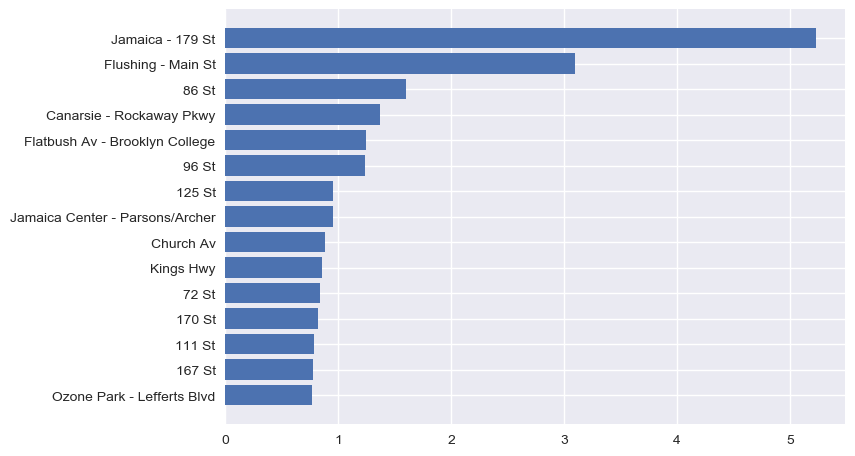

In [494]:
# plot a horizontal bar graph with the top 15 stations by percent of women responding to census
categories = df_station_top['Stop Name']
values = df_station_top['Women_Pct']

plt.figure(dpi=100)

plt.barh(np.arange(len(categories)), values[::-1])

plt.yticks(np.arange(len(categories)),
           ['{}'.format(x) for x in categories[::-1]]);

In [561]:
# save off the index to order other graphs in the same way 
df_station_top['new_index'] = df_station_top.reset_index().index

The same steps above are repeated for transit and employment industry.

In [563]:
df_transit_merge = pd.merge(df_census_transit,df_station_top[["Stop Name","CensusTract","new_index"]],on='CensusTract')

In [588]:
df_empl_merge = pd.merge(df_census_empl,df_station_top[["Stop Name","CensusTract","new_index"]],on='CensusTract')

In [586]:
df_transit_top = df_transit_merge[df_transit_merge["Stop Name"].isin(df_station_top["Stop Name"].values)][["Stop Name","Transit","new_index"]].groupby(["Stop Name"]).mean().sort_values(by=["new_index"]).reset_index().head(15)

In [591]:
df_empl_top = df_empl_merge[df_empl_merge["Stop Name"].isin(df_station_top["Stop Name"].values)][["Stop Name","Professional","new_index"]].groupby(["Stop Name"]).mean().sort_values(by=["new_index"]).reset_index().head(15)

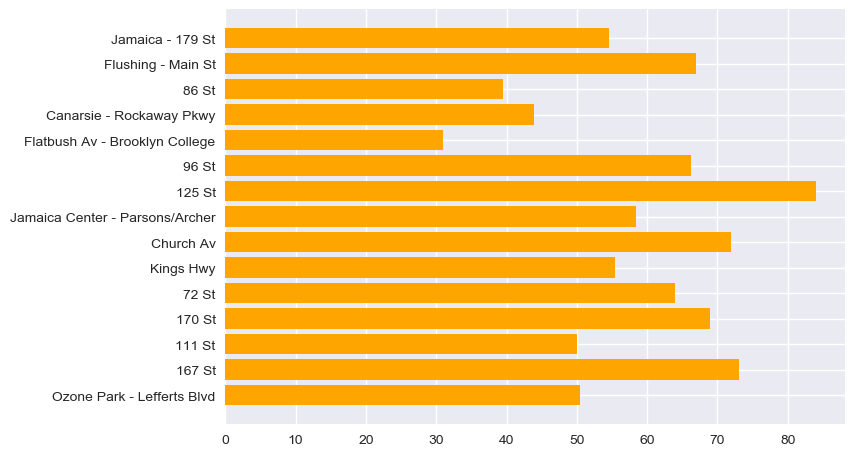

In [579]:
categories = df_transit_top['Stop Name']
values = df_transit_top['Transit']

plt.figure(dpi=100)

plt.barh(np.arange(len(categories)),values[::-1],color='orange')

plt.yticks(np.arange(len(categories)),
           ['{}'.format(x) for x in categories[::-1]]);

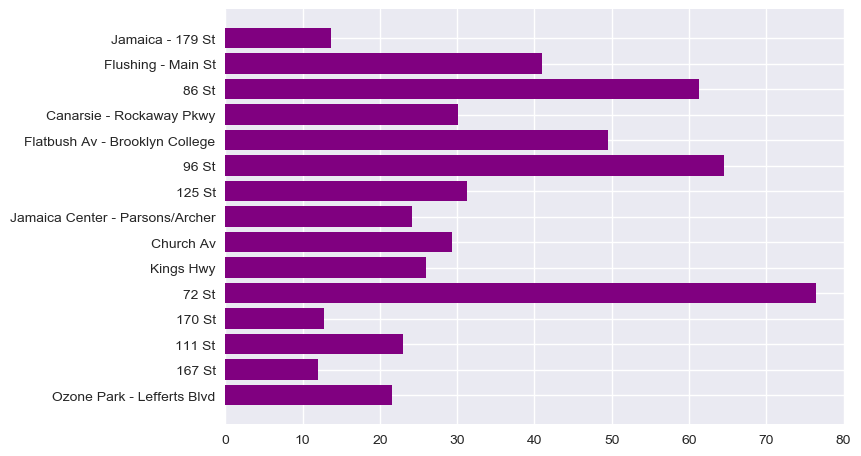

In [592]:
categories = df_empl_top['Stop Name']
values = df_empl_top['Professional']

plt.figure(dpi=100)

plt.barh(np.arange(len(categories)),values[::-1],color='purple')

plt.yticks(np.arange(len(categories)),
           ['{}'.format(x) for x in categories[::-1]]);

In [615]:
station_top_list = df_station_top["Stop Name"].values.tolist()

transit_top_list = list(df_transit_top["Transit"].values)

empl_top_list = list(df_empl_top["Professional"].values)

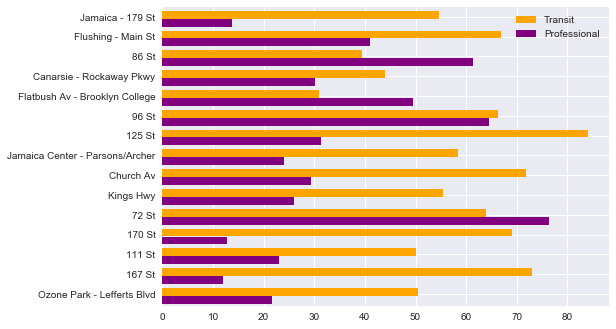

In [658]:
df_station_metrics = pd.DataFrame(dict(graph=station_top_list,
                           transit=transit_top_list, 
                           empl=empl_top_list))

plt.figure(dpi=500)
ind = np.arange(len(df_station_metrics))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df_station_metrics.transit[::-1], width, color='orange', label='Transit')
ax.barh(ind - width, df_station_metrics.empl[::-1], width, color='purple', label='Professional')

ax.set(yticks=ind + width-0.5, yticklabels=df_station_metrics.graph[::-1], ylim=[2*width-1.5, len(df_station_metrics)-.6])
ax.legend();